### Setup

In [11]:
from wearsed.dataset.WearSEDDataset import WearSEDDataset
from wearsed.models.vae.VAE import VAE as VAE_Lin_1s
from wearsed.models.vae.VAE_5s import VAE as VAE_Lin_5s
from wearsed.models.vae.VAE_conv import VAE as VAE_Conv_1s
from wearsed.models.vae.VAE_conv_5s import VAE as VAE_Conv_5s

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import torch

In [20]:
model_lin_1s = VAE_Lin_1s()
model_lin_1s.load_state_dict(torch.load('../wearsed/training/vae/output/bs_256_epochs_10/latent_size_8/model.pth', weights_only=True, map_location='cpu'))
model_lin_1s.eval()

model_lin_5s = VAE_Lin_5s()
model_lin_5s.load_state_dict(torch.load('../wearsed/training/vae/output_5s/model_final.pth', weights_only=True, map_location='cpu'))
model_lin_5s.eval()

model_conv_1s = VAE_Conv_1s()
model_conv_1s.load_state_dict(torch.load('../wearsed/training/vae/output_conv/model_final.pth', weights_only=True, map_location='cpu'))
model_conv_1s.eval()

model_conv_5s = VAE_Conv_5s()
model_conv_5s.load_state_dict(torch.load('../wearsed/training/vae/output_conv_5s/model_final.pth', weights_only=True, map_location='cpu'))
model_conv_5s.eval()

models = {
    'lin_1s': (model_lin_1s, False),
    'lin_5s': (model_lin_5s, True),
    'conv_1s': (model_conv_1s, False),
    'conv_5s': (model_conv_5s, True),
}

In [19]:
SIGNAL, FREQ = 'Pleth', 256

dataset = WearSEDDataset(mesaid_path='../wearsed/dataset/data_ids/', signals_to_read=[SIGNAL], return_recording=True)
signal = dataset[1].psg[SIGNAL]

In [86]:
def show_recon(ts):
    model_names = list(models.keys())
    _, axs = plt.subplots(len(model_names), 1, figsize=(20, len(model_names)*3), sharex=True)
    start, end = ts-5*FREQ, ts+5*FREQ
    for i, model_name in enumerate(model_names):
        model, windowed = models[model_name]
        signal_recon = []
        for sec_idx in range(start, end, FREQ):
            second = signal[sec_idx:sec_idx+FREQ] if not windowed else signal[sec_idx-2*FREQ:sec_idx+3*FREQ]
            second_tensor = torch.tensor(second.values, dtype=torch.float).view(1, -1)
            signal_recon.append(model(second_tensor)[0][0].detach())
        signal_recon = pd.Series(torch.cat(signal_recon).numpy(), index=range(start, end))

        axs[i].vlines(list(range(start, end, FREQ)), ymin=signal[start:end].min(), ymax=signal[start:end].max(), colors='grey', label=model_name)
        signal[start:end].plot(ax=axs[i])
        signal_recon.plot(ax=axs[i])
        axs[i].legend()
    plt.show()

### Reconstructions

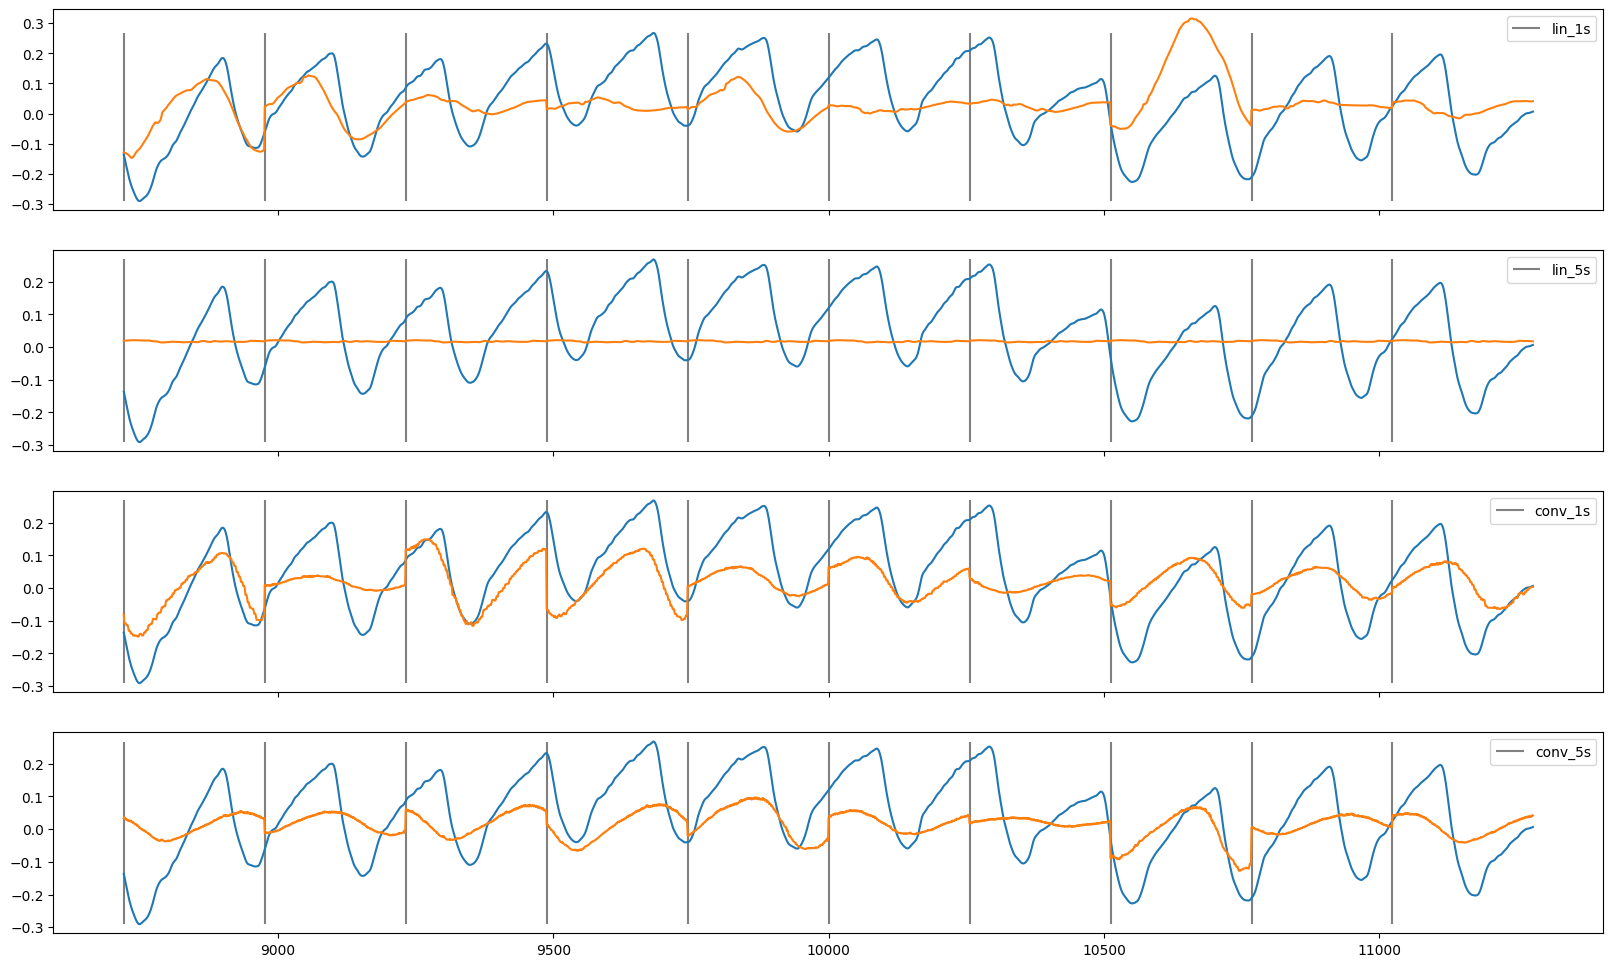

In [87]:
show_recon(10000)

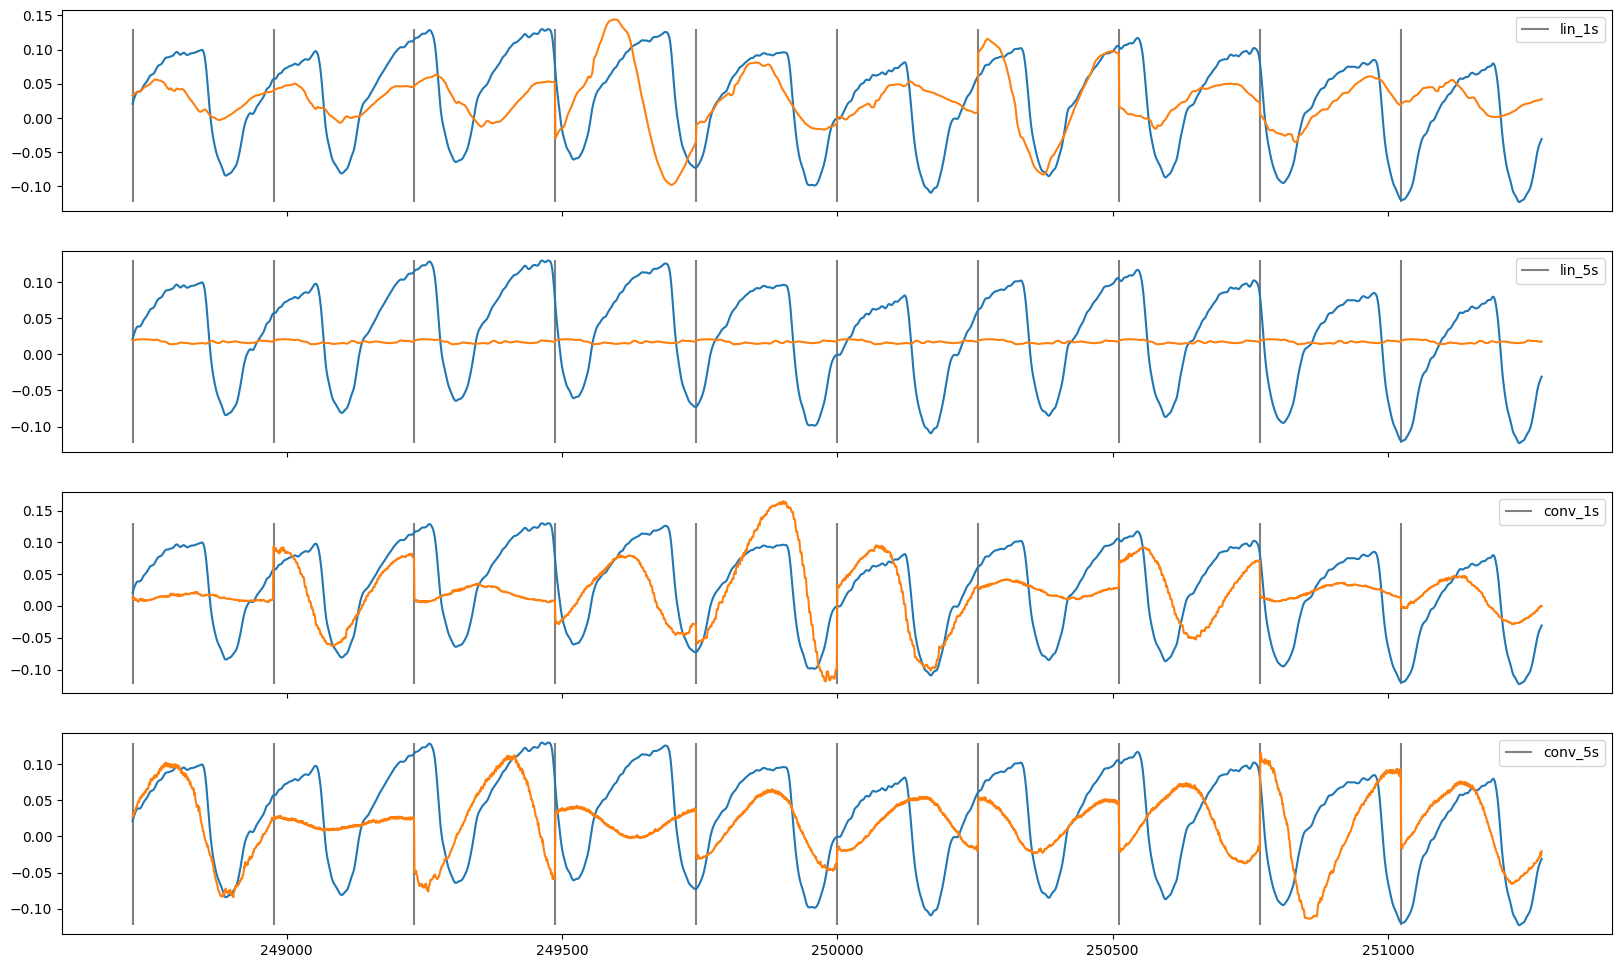

In [92]:
show_recon(250000)